## Homework #10

##### Author: [Radoslav Neychev](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import FashionMNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

from tqdm import tqdm

### Task #1:
Let's return to the handwritten digit recognition problem discussed in the first lesson. We will also work with the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. In this task we will use the entire dataset.

__Your main task: implement the entire model training pipeline and achieve a quality of $\geq 88.5\%$ on the test sample.__

There is no code for training the model in this task. There are only a few tests that will help you debug your solution. For an example, you can refer to the notebooks from previous classes.

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# __________end of block__________

100%|██████████| 26421880/26421880 [00:05<00:00, 4774868.64it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 1218861.46it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4548781.93it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 2132359.96it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Text(0.5, 1.0, 'Image label: 4')

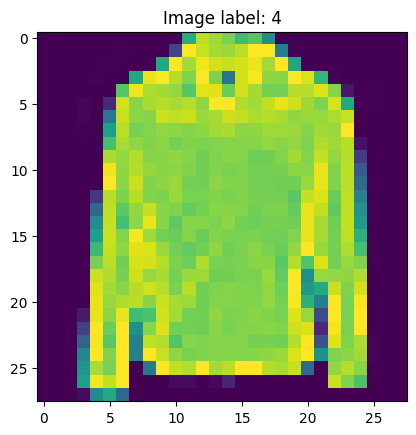

In [3]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_fmnist_data = FashionMNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Build the model below. Please do not build an over-complicated network; you should not make it deeper than four layers (fewer is possible). Your main task is to train the model and obtain quality on the deferred (test sample) of at least 88.5% accuracy.

__Attention, your model must be represented by the `model` variable. It should receive a tensor of dimension (1, 28, 28) as input.__

In [4]:
# Creating model instance

# make convolutional neural network

model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(128 * 3 * 3, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)


Don't forget to transfer the model to the selected `device`!

In [5]:
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=10, bias=True)
)

Local tests to validate your model are available below:

In [6]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model(x)    
except Exception as e:
    print('Something is wrong with the model')
    raise e
    
    
assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Tune the model parameters on the training set. We also recommend working with `learning rate`.

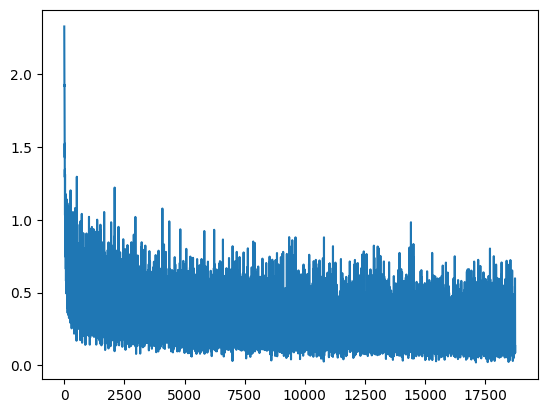

In [7]:
# your code here

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss = []

for epoch in range(10):
    for x, y in tqdm(train_data_loader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss_value = loss(y_pred, y)
        loss_value.backward()
        optimizer.step()
        train_loss.append(loss_value.item())
        
    clear_output(True)
    plt.plot(train_loss)
    plt.show()

Also, we remind you that you can refer to the excellent [documentation](https://pytorch.org/docs/stable/index.html) and [training examples](https://pytorch.org/tutorials/) at any time.

Let's evaluate the quality of classification:

In [8]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].to(device))
        predicted_labels.append(y_predicted.argmax(dim=1).cpu())
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [9]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.91572


In [10]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].to(device))
        predicted_labels.append(y_predicted.argmax(dim=1).cpu())
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [11]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.8828


Checking that the required thresholds have been passed:

In [12]:
assert test_acc >= 0.885, 'Train accuracy is below 0.885 threshold'
assert train_acc >= 0.905, 'Test accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow'

AssertionError: Train accuracy is below 0.885 threshold

### Submitting the task
Download the file `hw10_data_dict.npy` (the link is on the task page) and run the code below to generate the parcel. The code below can load it (but if there is an error, please download and load it manually).

In [ ]:
!wget https://github.com/girafe-ai/ml-course/raw/23s_dd_ml/homeworks/hw10_fmnist/hw10_data_dict.npy

In [ ]:
# do not change the code in the block below
# __________start of block__________
import os

assert os.path.exists('hw10_data_dict.npy'), 'Please, download `hw10_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):
    
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
    
    predicted_labels = torch.cat(predicted_labels)
    return predicted_labels

loaded_data_dict = np.load('hw10_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])).numpy(),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test'])).numpy()
}

np.save('submission_dict_hw10.npy', submission_dict, allow_pickle=True)
print('File saved to `submission_dict_hw10.npy`')
# __________end of block__________

This completes the task. Congratulations!